In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords

# Download the stop words from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = ' '.join([word for word in word_tokens if word.lower() not in stop_words])
    return filtered_text
df = pd.read_csv("/content/drive/MyDrive/Cooking_Dataset/Cooking_Dataset/train.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = df[0:5000]
for x in range(len(df['Recipe'])):
    if type(df['Recipe'][x]) != str:
        df['Recipe'][x] = ''
df2 = pd.read_csv("/content/drive/MyDrive/Cooking_Dataset/Cooking_Dataset/dev.csv")
for x in range(len(df2['Recipe'])):
    if type(df2['Recipe'][x]) != str:
        df2['Recipe'][x] = ''
# Apply the function to the DataFrame columns
df['Ingredients'] = df['Ingredients'].apply(remove_stop_words)
df['Recipe'] = df['Recipe'].apply(remove_stop_words)
df['Ingredients'] = df['Ingredients'].str.lower()
df['Recipe'] = df['Recipe'].str.lower()
df2['Ingredients'] = df2['Ingredients'].apply(remove_stop_words)
df2['Recipe'] = df2['Recipe'].apply(remove_stop_words)
df2['Ingredients'] = df2['Ingredients'].str.lower()
df2['Recipe'] = df2['Recipe'].str.lower()

In [7]:
import pandas as pd
import re
import unicodedata
import random
import torch


file_path = ""

# MAX_LENGTH = df['Ingredients'].str.len().max()
MAX_LENGTH = 150
print("Maximum length of strings in 'Ingredients' column:", MAX_LENGTH)
with open("1.txt", "w") as file:
    for index, row in df.iterrows():
        file.write(f"{row['Recipe']}:::{row['Ingredients']}\n")

SOS_token = 0
EOS_token = 1
UNK_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
        self.n_words = 3  # Count SOS, EOS, and UNK

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    file_name = file_path + '1.txt'
    lines = open(file_name, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split(':::')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'eng2', True)
print(random.choice(pairs))

def indexesFromSentence(lang, sentence):
    return [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

with open("2.txt", "w") as file:
    for index, row in df2.iterrows():
        file.write(f"{row['Recipe']}:::{row['Ingredients']}\n")

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    file_name = file_path + '2.txt'
    lines = open(file_name, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split(':::')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

dev_input_lang, dev_output_lang, dev_pairs = prepareData('eng', 'eng2', True)
print(random.choice(dev_pairs))


Maximum length of strings in 'Ingredients' column: 150
Reading lines...
Read 5000 sentence pairs
Trimmed to 4747 sentence pairs
Counting words...
Counted words:
eng2 4346
eng 8018
[' c powdered sugar sifted ds salt c raspberries fresh crushed ts lemon juice', 'add sugar salt crushed fruit mixing well . add lemon juice consistency spread thinly cake .']
Reading lines...
Read 797 sentence pairs
Trimmed to 764 sentence pairs
Counting words...
Counted words:
eng2 1891
eng 3506
[' lb boneless lamb leg shoulder tb kikkoman soy sauce divided tb cornstarch garlic cloves pressed ts cornstarch ts sesame seed toasted ts sugar ts to . . . ts crushed red pepper tb vegetable oil divided carrots cut diagonally thin slices bn green onions cut inch lengths separating whites tops', 'cut lamb across grain thin slices . combine tbsp . soy sauce cornstarch garlic stir lamb . let stand minutes . meanwhile combine remaining soy sauce cup water next ingredients set aside . heat tbsp . oil hot wok large skille

BASELINE 1

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device), torch.zeros(1, 1, self.hidden_size, device=device)

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device), torch.zeros(1, 1, self.hidden_size, device=device)

In [10]:
teacher_forcing_ratio = 1
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length

In [11]:
import time
import math
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [12]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    dll = []
    print_loss_total = 0
    plot_loss_total = 0
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    dev_pairs2 = [tensorsFromPair(random.choice(dev_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            # Calculate development loss
            dl = 0
            with torch.no_grad():
              for d in dev_pairs2:
                input_tensor = d[0]
                target_tensor = d[1]
                loss2 = evaluate2(input_tensor, target_tensor, encoder, decoder,criterion)
                dl += loss2
            dl / len(dev_pairs2)
            dl_avg = dl / len(dev_pairs2)
            dll.append((iter, dl_avg))
            print('Dev Loss is: %.4f' % dl_avg)
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append((iter, plot_loss_avg))
            plot_loss_total = 0
    showPlot(plot_losses, dll)

def evaluate2(input_tensor, target_tensor, encoder, decoder, criterion):
    with torch.no_grad():
        encoder_hidden = encoder.initHidden()
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
        loss = 0
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    return loss.item() / target_length

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()
        return decoded_words

In [13]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
def showPlot(tl, dl):
    plt.figure()
    fig, ax = plt.subplots()
    tli, tlv = zip(*tl)
    di, dv = zip(*dl)
    ax.plot(tli, tlv, 'b-', label='Training Loss')
    ax.plot(di, dv, 'r--', label='Development Loss')
    ax.set_xlabel('Iterations numbers')
    ax.set_ylabel('Loss values')
    ax.set_title('Training and Dev Losses')
    ax.legend()
    plt.show()

1m 47s (- 16m 5s) (1000 10%) 5.6204
3m 30s (- 14m 3s) (2000 20%) 4.6957
5m 19s (- 12m 25s) (3000 30%) 4.3003
7m 1s (- 10m 32s) (4000 40%) 4.1154
8m 47s (- 8m 47s) (5000 50%) 3.9635
10m 28s (- 6m 58s) (6000 60%) 3.9020
12m 9s (- 5m 12s) (7000 70%) 3.7998
13m 55s (- 3m 28s) (8000 80%) 3.7220
15m 37s (- 1m 44s) (9000 90%) 3.6506
17m 21s (- 0m 0s) (10000 100%) 3.6052


<Figure size 640x480 with 0 Axes>

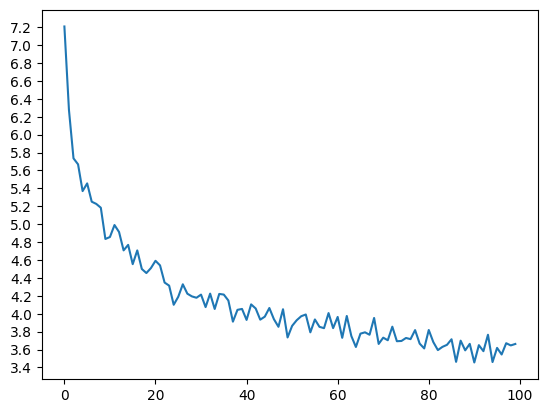

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 10000, print_every=1000)

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
trainIters(encoder1, decoder1, 10000, print_every=1000)

1m 27s (- 13m 7s) (1000 10%) 5.9084
6m 29s (- 25m 58s) (2000 20%) 5.8311
11m 1s (- 25m 44s) (3000 30%) 5.5978
15m 29s (- 23m 14s) (4000 40%) 5.5279


KeyboardInterrupt: 

1m 33s (- 14m 0s) (1000 10%) Training Loss: 5.2320
Dev Loss: 4.0537
3m 19s (- 13m 17s) (2000 20%) Training Loss: 4.7244
Dev Loss: 7.5774
5m 19s (- 12m 25s) (3000 30%) Training Loss: 4.5549
Dev Loss: 3.7351
7m 6s (- 10m 40s) (4000 40%) Training Loss: 4.4544
Dev Loss: 3.8976
8m 55s (- 8m 55s) (5000 50%) Training Loss: 4.4258
Dev Loss: 8.6804
10m 55s (- 7m 17s) (6000 60%) Training Loss: 4.3670
Dev Loss: 4.7012
12m 43s (- 5m 27s) (7000 70%) Training Loss: 4.3279
Dev Loss: 7.7667
14m 40s (- 3m 40s) (8000 80%) Training Loss: 4.3119
Dev Loss: 5.5144
16m 26s (- 1m 49s) (9000 90%) Training Loss: 4.3015
Dev Loss: 5.1630
18m 17s (- 0m 0s) (10000 100%) Training Loss: 4.2576
Dev Loss: 5.0244


<Figure size 640x480 with 0 Axes>

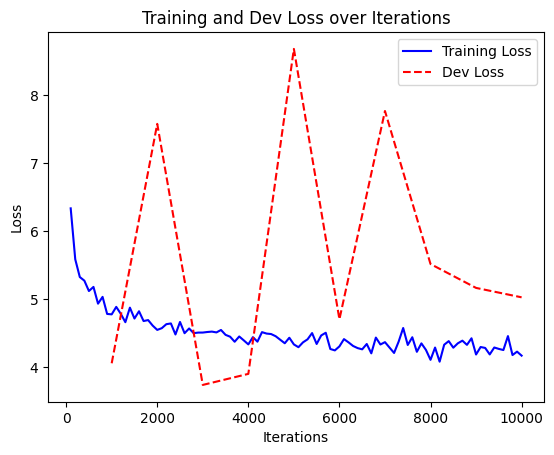

In [22]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 10000, print_every=1000)

Baseline 2 with attention

In [14]:
import torch
import torch.nn as nn

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self,device):
        return torch.zeros(1, 1, self.hidden_size, device=device), torch.zeros(1, 1, self.hidden_size, device=device)

In [15]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)  # Change GRU to LSTM
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        _, (hidden, cell_state) = self.lstm(embedded, hidden)  # Change GRU to LSTM

        attn_weights = F.softmax(torch.bmm(hidden, encoder_outputs.T.unsqueeze(0)), dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_outputs.unsqueeze(0))

        concat_output = torch.cat((attn_output[0], hidden[0]), 1)

        output = F.log_softmax(self.out(concat_output), dim=1)

        return output, (hidden, cell_state), attn_weights

    def initHidden(self,device):
        return torch.zeros(1, 1, self.hidden_size, device=device), torch.zeros(1, 1, self.hidden_size, device=device)

In [16]:
teacher_forcing_ratio = 1

def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden, encoder_cell = encoder.initHidden(device)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, (encoder_hidden, encoder_cell) = encoder(
            input_tensor[ei], (encoder_hidden, encoder_cell))
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell  # Initialize decoder's cell state with encoder's last cell state

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, (decoder_hidden, decoder_cell), decoder_attention = decoder(
                decoder_input, (decoder_hidden, decoder_cell), encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, (decoder_hidden, decoder_cell), decoder_attention = decoder(
                decoder_input, (decoder_hidden, decoder_cell), encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [17]:
def evaluate_attn(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden, encoder_cell = encoder.initHidden(device)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor[ei],
                                                     (encoder_hidden, encoder_cell))
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell  # Initialize decoder's cell state with encoder's last cell state

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, (decoder_hidden, decoder_cell), decoder_attention = decoder(
                decoder_input, (decoder_hidden, decoder_cell), encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [18]:
def trainIters_attn(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    dll =  []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    dev_pairs2 = [tensorsFromPair(random.choice(dev_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        encoder_hidden, encoder_cell = encoder.initHidden(device)  # Initialize encoder's hidden and cell states
        decoder_hidden, decoder_cell = encoder_hidden, encoder_cell  # Initialize decoder's hidden and cell states
        loss = train_attn(input_tensor, target_tensor, encoder,
                          decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            # Calculate development loss
            dl = 0
            with torch.no_grad():
              for d in dev_pairs2:
                input_tensor = d[0]
                target_tensor = d[1]
                loss2 = evaluate3(input_tensor, target_tensor, encoder, decoder,criterion)
                dl += loss2
            dl / len(dev_pairs2)
            dl_avg = dl / len(dev_pairs2)
            dll.append((iter, dl_avg))
            print('Dev Loss is: %.4f' % dl_avg)
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append((iter, plot_loss_avg))
            plot_loss_total = 0
    showPlot(plot_losses,dll)

In [19]:
def evaluate3(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    with torch.no_grad():
        # Initialize the encoder's hidden and cell states
        encoder_hidden, encoder_cell = encoder.initHidden(device)
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        # Encode the input sentence
        for ei in range(input_length):
            encoder_output, (encoder_hidden, encoder_cell) = encoder(
                input_tensor[ei], (encoder_hidden, encoder_cell))
            encoder_outputs[ei] = encoder_output[0, 0]
        # Initialize the decoder input and hidden states
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell
        # Initialize tensor to store decoder outputs
        decoder_outputs = torch.zeros(target_length, decoder.output_size, device=device)
        # Decode the input sentence
        for di in range(target_length):
            decoder_output, (decoder_hidden, decoder_cell), decoder_attention = decoder(
                decoder_input, (decoder_hidden, decoder_cell), encoder_outputs)
            decoder_outputs[di] = decoder_output
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            if decoder_input.item() == EOS_token:
                break
        loss = criterion(decoder_outputs, target_tensor.view(-1))
        return loss.item() / target_length

1m 54s (- 17m 11s) (1000 10%) 5.5581
Dev Loss is: 0.1620
9m 4s (- 36m 19s) (2000 20%) 5.1478
Dev Loss is: 0.0877
13m 34s (- 31m 40s) (3000 30%) 4.8535
Dev Loss is: 0.1630
21m 10s (- 31m 46s) (4000 40%) 4.8525
Dev Loss is: 0.1456
28m 9s (- 28m 9s) (5000 50%) 4.6926
Dev Loss is: 0.1078
33m 40s (- 22m 26s) (6000 60%) 4.6398
Dev Loss is: 0.1482
40m 34s (- 17m 23s) (7000 70%) 4.6266
Dev Loss is: 0.1783
48m 15s (- 12m 3s) (8000 80%) 4.4735
Dev Loss is: 0.1652
55m 19s (- 6m 8s) (9000 90%) 4.4782
Dev Loss is: 0.1810
63m 7s (- 0m 0s) (10000 100%) 4.4385
Dev Loss is: 0.1702


<Figure size 640x480 with 0 Axes>

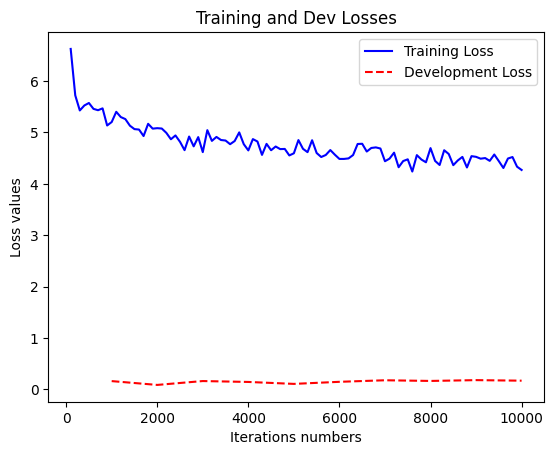

In [20]:
hidden_size = 256
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
trainIters_attn(encoder2, attn_decoder, 10000, print_every=1000)

In [21]:
torch.save(encoder2.state_dict(), 'encoderatten.pth')
torch.save(attn_decoder.state_dict(), 'decoderatten.pth')

# Save the trainIters function
import pickle
with open('trainItersatten.pkl', 'wb') as f:
    pickle.dump(trainIters_attn, f)

Extention 1 with word2vec embeddings

In [ ]:
import gensim
from gensim.models import KeyedVectors

# Load the Word2Vec model
embedding_path = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz'
word2vec_model = KeyedVectors.load_word2vec_format(embedding_path, binary=True)

In [ ]:
import numpy as np

def create_embedding_matrix(word2index, embedding_model):
    embedding_dim = embedding_model.vector_size
    vocab_size = max(word2index.values()) + 1  # Ensure size is enough for the highest index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in word2index.items():
        if word in embedding_model:
            embedding_matrix[idx] = embedding_model[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return embedding_matrix

# Assuming 'input_lang' is already created as per your code
embedding_matrix = create_embedding_matrix(input_lang.word2index, word2vec_model)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



class EmbeddingLayer(nn.Module):
    def __init__(self, embedding_matrix):
        super(EmbeddingLayer, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # Freeze embeddings

    def forward(self, x):
        return self.embedding(x)

class EncoderRNN(nn.Module):
    def __init__(self, embedding_layer, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(embedding_layer.embedding.embedding_dim, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def initHidden(self, device):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self, device):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

In [ ]:
hidden_size = 256
encoder3 = EncoderRNN(embedding_layer, hidden_size).to(device)
decoder3 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
trainIters(encoder3, decoder3, 10000, print_every=1000)

Extextion 4: with stacked layers in encoder and decoder

In [ ]:
import torch
import torch.nn as nn

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, additional_layers=4):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.additional_layers = additional_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size,2)

        # Additional fully connected layers
        self.additional_fcs = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(additional_layers)])

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.lstm(embedded, hidden)

        # Pass the output through additional fully connected layers
        for fc in self.additional_fcs:
            output = fc(output)
            output = torch.relu(output)  # You can use other activation functions as well

        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, additional_layers=4):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.additional_layers = additional_layers

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size,2)

        # Additional fully connected layers
        self.additional_fcs = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(additional_layers)])

        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = torch.relu(output)
        output, hidden = self.lstm(output, hidden)

        # Pass the output through additional fully connected layers
        for fc in self.additional_fcs:
            output = fc(output)
            output = torch.relu(output)  # You can use other activation functions as well

        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

In [ ]:
hidden_size = 256
encoder4 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder4 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
trainIters(encoder4, decoder4, 10000, print_every=1000)

Testing and evaluation

In [24]:
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = ' '.join([word for word in word_tokens if word.lower() not in stop_words])
    return filtered_text
df3 = pd.read_csv("/content/drive/MyDrive/Cooking_Dataset/Cooking_Dataset/test.csv")
for x in range(len(df3['Recipe'])):
    if type(df3['Recipe'][x]) != str:
        df3['Recipe'][x] = ''
# Apply the function to the DataFrame columns
df3['Ingredients'] = df3['Ingredients'].apply(remove_stop_words)
df3['Recipe'] = df3['Recipe'].apply(remove_stop_words)

In [25]:
with open("3.txt", "w") as file:
    for index, row in df3.iterrows():
        file.write(f"{row['Recipe']}:::{row['Ingredients']}\n")

def readLangs(lang1, lang2, reverse=False, file_name='3.txt'):
    print("Reading lines...")
    # Read the file and split into lines
    file_name = file_path + file_name
    lines = open(file_name, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split(':::')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False, file_name='3.txt'):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse, file_name)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

def indexesFromSentence(lang, sentence):
    return [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# Process test data
test_input_lang, test_output_lang, test_pairs = prepareData('eng', 'fra', True, '3.txt')
print(random.choice(test_pairs))


Reading lines...
Read 778 sentence pairs
Trimmed to 742 sentence pairs
Counting words...
Counted words:
fra 1849
eng 3207
[' inch middle eastern cracker bread round called la vosh oz neufchatel cheese room temperature sm slices lean bacon cooked crisp drained paper towel tb finely chopped celery green onion oz thinly sliced cooked turkey ripe avocado peeled hopped tb lemon juice several leaves romaine lettuce hard core removed freshly ground pepper', 'set aside wrapped clean damp towel . small bowl standing hot water soften whip neufchatel cheese spreading consistency . crumble bacon stir cheese celery onion . using rubber spatula spread cheese thinly softened cracker bread . cover turkey slices . dip avocado lemon juice place top turkey . arrange romaine leaves single layer . sprinkle pepper . roll bread tightly enclose filling . wrap plastic chill ready serve . serving remove plastic wrap slice diagonal slices . neufchatel cheese case wondering looks tastes like cream cheese counts m

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence).to(device)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        # Move each element of the encoder_hidden tuple to the device
        encoder_hidden = tuple(h.to(device) for h in encoder_hidden)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden

        decoded_words = []
        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach().to(device)

        return decoded_words


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from tqdm import tqdm

def evaluate_bleu(encoder, decoder, test_pairs):
    references = []  # Stores reference sentences for each prediction
    hypotheses = []  # Stores predicted sentences

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Removing <SOS> and <EOS> tokens from target_sentence
        target_sentence = target_sentence.split()
        if target_sentence[0] == "SOS":
            target_sentence = target_sentence[1:]
        if target_sentence[-1] == "EOS":
            target_sentence = target_sentence[:-1]

        references.append([target_sentence])
        hypotheses.append(output_words)

    bleu_score = corpus_bleu(references, hypotheses)
    return bleu_score

def evaluate_bleu2(encoder, decoder, test_pairs):
    references = []  # Stores reference sentences for each prediction
    hypotheses = []  # Stores predicted sentences

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate_attn(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Removing <SOS> and <EOS> tokens from target_sentence
        target_sentence = target_sentence.split()
        if target_sentence[0] == "SOS":
            target_sentence = target_sentence[1:]
        if target_sentence[-1] == "EOS":
            target_sentence = target_sentence[:-1]

        references.append([target_sentence])
        hypotheses.append(output_words)

    bleu_score = corpus_bleu(references, hypotheses)
    return bleu_score
# Assuming you have test_pairs variable containing test data
encoder1 = encoder1.to(device)
decoder1 = decoder1.to(device)

# bleu_score1 = evaluate_bleu(encoder1, decoder1, test_pairs)
bleu_score2 = evaluate_bleu2(encoder2, attn_decoder, test_pairs)
# bleu_score3 = evaluate_bleu(encoder3, decoder3, test_pairs)
# bleu_score4 = evaluate_bleu(encoder4, decoder4, test_pairs)

print("BLEU-4 Score1:", bleu_score1)  # BLEU-4 Score1
print("BLEU-4 Score2:", bleu_score2)  # BLEU-4 Score2
print("BLEU-4 Score3:", bleu_score3)  # BLEU-4 Score3
print("BLEU-4 Score4:", bleu_score4)  # BLEU-4 Score4


100%|██████████| 742/742 [00:15<00:00, 47.72it/s]

BLEU-4 Score: 0.001473733991008767


In [27]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from tqdm import tqdm

def evaluate_bleu(encoder, decoder, test_pairs):
    references = []  # Stores reference sentences for each prediction
    hypotheses = []  # Stores predicted sentences

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Removing <SOS> and <EOS> tokens from target_sentence
        target_sentence = target_sentence.split()
        if target_sentence[0] == "SOS":
            target_sentence = target_sentence[1:]
        if target_sentence[-1] == "EOS":
            target_sentence = target_sentence[:-1]

        references.append([target_sentence])
        hypotheses.append(output_words)

    bleu_score = corpus_bleu(references, hypotheses)
    return bleu_score

def evaluate_bleu2(encoder, decoder, test_pairs):
    references = []  # Stores reference sentences for each prediction
    hypotheses = []  # Stores predicted sentences

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate_attn(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Removing <SOS> and <EOS> tokens from target_sentence
        target_sentence = target_sentence.split()
        if target_sentence[0] == "SOS":
            target_sentence = target_sentence[1:]
        if target_sentence[-1] == "EOS":
            target_sentence = target_sentence[:-1]

        references.append([target_sentence])
        hypotheses.append(output_words)

    bleu_score = corpus_bleu(references, hypotheses)
    return bleu_score
# Assuming you have test_pairs variable containing test data
encoder2 = encoder2.to(device)
attn_decoder = attn_decoder.to(device)

# bleu_score1 = evaluate_bleu(encoder1, decoder1, test_pairs)
bleu_score2 = evaluate_bleu2(encoder2, attn_decoder, test_pairs)
# bleu_score3 = evaluate_bleu(encoder3, decoder3, test_pairs)
# bleu_score4 = evaluate_bleu(encoder4, decoder4, test_pairs)

# print("BLEU-4 Score1:", bleu_score1)  # BLEU-4 Score1
print("BLEU-4 Score2:", bleu_score2)  # BLEU-4 Score2
# print("BLEU-4 Score3:", bleu_score3)  # BLEU-4 Score3
# print("BLEU-4 Score4:", bleu_score4)  # BLEU-4 Score4


  0%|          | 0/742 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
from nltk.translate.meteor_score import meteor_score
def evaluate_meteor(encoder, decoder, test_pairs):
    references = []  # Stores reference sentences for each prediction
    hypotheses = []  # Stores predicted sentences

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Split reference sentence into tokens
        target_tokens = target_sentence.strip().split()

        references.append(target_tokens)
        hypotheses.append(output_sentence)

    meteor_avg = meteor_score(references, hypotheses)
    return meteor_avg


def evaluate_meteor2(encoder, decoder, test_pairs):
    references = []  # Stores reference sentences for each prediction
    hypotheses = []  # Stores predicted sentences

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate_attn(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Split reference sentence into tokens
        target_tokens = target_sentence.strip().split()

        references.append(target_tokens)
        hypotheses.append(output_sentence)

    meteor_avg = meteor_score(references, hypotheses)
    return meteor_avg
# Assuming you have test_pairs variable containing test data
meteor_score1 = evaluate_meteor(encoder1, decoder1, test_pairs)
meteor_score2 = evaluate_meteor2(encoder2, attn_decoder, test_pairs)
meteor_score3 = evaluate_meteor(encoder3, decoder3, test_pairs)
meteor_score4 = evaluate_meteor(encoder4, decoder4, test_pairs)
print("METEOR Score1:", meteor_score1)  # METEOR Score1
print("METEOR Score2:", meteor_score2)  # METEOR Score2
print("METEOR Score3:", meteor_score3)  # METEOR Score3
print("METEOR Score4:", meteor_score4)  # METEOR Score4



100%|██████████| 742/742 [00:19<00:00, 37.93it/s]


METEOR Score: 0.0


In [ ]:
def evaluate_accuracy(encoder, decoder, test_pairs):
    total_correct = 0
    total_items = 0

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Tokenize target and output sentences for comparison
        target_tokens = target_sentence.strip().split()
        output_tokens = output_sentence.strip().split()

        # Calculate number of correctly predicted items
        correct_items = sum(1 for token in output_tokens if token in target_tokens)

        total_correct += correct_items
        total_items += len(target_tokens)

    avg_accuracy = (total_correct / total_items) * 100 if total_items > 0 else 0
    return avg_accuracy

def evaluate_accuracy2(encoder, decoder, test_pairs):
    total_correct = 0
    total_items = 0

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate_attn(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Tokenize target and output sentences for comparison
        target_tokens = target_sentence.strip().split()
        output_tokens = output_sentence.strip().split()

        # Calculate number of correctly predicted items
        correct_items = sum(1 for token in output_tokens if token in target_tokens)

        total_correct += correct_items
        total_items += len(target_tokens)

    avg_accuracy = (total_correct / total_items) * 100 if total_items > 0 else 0
    return avg_accuracy
# Assuming you have test_pairs variable containing test data
accuracy1 = evaluate_accuracy(encoder1, decoder1, test_pairs)
accuracy2 = evaluate_accuracy2(encoder2, attn_decoder, test_pairs)
accuracy3 = evaluate_accuracy(encoder3, decoder3, test_pairs)
accuracy4 = evaluate_accuracy(encoder4, decoder4, test_pairs)
print("Average Accuracy1 (%):", accuracy1)
print("Average Accuracy2 (%):", accuracy2)
print("Average Accuracy3 (%):", accuracy3)
print("Average Accuracy4 (%):", accuracy4)


100%|██████████| 742/742 [00:13<00:00, 53.40it/s]

Average Accuracy (%): 14.521298834022389


In [ ]:
def evaluate_extra_items(encoder, decoder, test_pairs):
    total_extra_items = 0
    total_sentences = len(test_pairs)

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Tokenize target and output sentences for comparison
        target_tokens = set(target_sentence.strip().split())
        output_tokens = set(output_sentence.strip().split())

        # Calculate number of extra predicted items
        extra_items = len(output_tokens - target_tokens)

        total_extra_items += extra_items

    avg_extra_items = total_extra_items / total_sentences if total_sentences > 0 else 0
    return avg_extra_items

def evaluate_extra_items2(encoder, decoder, test_pairs):
    total_extra_items = 0
    total_sentences = len(test_pairs)

    for pair in tqdm(test_pairs):
        input_sentence = pair[0]
        target_sentence = pair[1]

        output_words = evaluate_attn(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words)

        # Tokenize target and output sentences for comparison
        target_tokens = set(target_sentence.strip().split())
        output_tokens = set(output_sentence.strip().split())

        # Calculate number of extra predicted items
        extra_items = len(output_tokens - target_tokens)

        total_extra_items += extra_items

    avg_extra_items = total_extra_items / total_sentences if total_sentences > 0 else 0
    return avg_extra_items

# Assuming you have test_pairs variable containing test data
avg_extra_items1 = evaluate_extra_items(encoder1, decoder1, test_pairs)
avg_extra_items2 = evaluate_extra_items2(encoder2, attn_decoder, test_pairs)
avg_extra_items3 = evaluate_extra_items(encoder3, decoder3, test_pairs)
avg_extra_items4 = evaluate_extra_items(encoder4, decoder4, test_pairs)
print("Average Extra Items1:", avg_extra_items1)
print("Average Extra Items2:", avg_extra_items2)
print("Average Extra Items3:", avg_extra_items3)
print("Average Extra Items4:", avg_extra_items4)


100%|██████████| 742/742 [00:14<00:00, 51.73it/s]

Average Extra Items: 3.6199460916442048


In [56]:
evaluateRandomly(encoder1, decoder1)

>  lb mushrooms tb oil tb water c milk tb corn starch dissolved c water salt parsley sprig sl luncheon ham
= select mushrooms unopened caps . cut stems mushrooms caps remain . retain mushroom stems soup . mince slice ham also mince parsley . assemble ingredients . place oil wok heat low medium heat minutes . add mushrooms wok stir fry minute . add tablespoons water cover wok gently stir fry mushrooms minutes . lift cover times stir mushrooms cooking period . mushrooms cooked remove platter . arrange mushrooms caps upright pour juices wok . place cup milk wok add thoroughly stirred corn starch solution . cook low medium heat white sauce thickened . pour white sauce mushroom caps garnish minced ham parsley .
< preheat oven degrees . add eggs . add eggs . add eggs . add eggs . add eggs . add eggs . <EOS>

>  sm onions garlic cloves ginger root piece cloves cinnamon stick cardamom pods salt water tb indian curry powder ts chili powder lb lamb cut bite size chunks tb ghee clarified butter o

In [54]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [55]:
sentence1 = ': 2 c sugar, 1/4 c lemon juice, 1 c water, 1/3 c orange juice, 8 c strawberries'
output_words= evaluate(encoder1, decoder1, sentence1)
output_sentence = ' '.join(output_words)
print('<', output_sentence)

< preheat oven degrees . add eggs . add eggs . add eggs . add eggs . <EOS>


In [ ]:
sentence1 = ': 2 c sugar, 1/4 c lemon juice, 1 c water, 1/3 c orange juice, 8 c strawberries'
output_words= evaluate_attn(encoder1, decoder1, sentence1)
output_sentence = ' '.join(output_words)
print('<', output_sentence)

In [ ]:
sentence1 = ': 2 c sugar, 1/4 c lemon juice, 1 c water, 1/3 c orange juice, 8 c strawberries'
output_words= evaluate(encoder1, decoder1, sentence1)
output_sentence = ' '.join(output_words)
print('<', output_sentence)

In [ ]:
sentence1 = ': 2 c sugar, 1/4 c lemon juice, 1 c water, 1/3 c orange juice, 8 c strawberries'
output_words= evaluate(encoder1, decoder1, sentence1)
output_sentence = ' '.join(output_words)
print('<', output_sentence)